# House Price Prediction

In [5]:
# library 
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.reset_option('display.max_rows')
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns
sns.set_theme(style='white') 
%matplotlib inline
import re
import math 
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import six  
from numpy import random as rand 
import plotly.io as pio
pio.renderers.default = "notebook_connected"
import plotly.figure_factory as ff
from sklearn.preprocessing import PowerTransformer,FunctionTransformer, KBinsDiscretizer,OrdinalEncoder, OneHotEncoder, LabelEncoder,StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mutual_info_score,mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error ,make_scorer
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression,SelectKBest, f_classif, f_regression,chi2, SelectPercentile,RFE,RFECV ,VarianceThreshold
from sklearn.model_selection import cross_val_score, cross_validate,StratifiedKFold,GridSearchCV,train_test_split
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.utils.class_weight import compute_class_weight
import shap 
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor, GradientBoostingRegressor
import xgboost as xgb 
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from kmodes.kprototypes import KPrototypes
from jcopml.tuning import grid_search_params 
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline
from scipy.stats import shapiro, normaltest 
from itertools import combinations
from scipy.stats import chi2_contingency,wilcoxon, mannwhitneyu, skew
import scipy.stats as ss
from IPython.display import Image 
import statsmodels.api as sm 
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv').drop(columns=['Id'])
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv').drop(columns=['Id'])

# Exploratory Data Analysis 

## Data Understanding

Kita kelompokkan data berdasarkan tipe datanya terlebih dahulu agar memudahkan proses EDA nantinya. Data dipisahkan menjadi 3, Numeric, Categoric Nominal, Categoric Ordinal.

In [8]:
num_cols = df.select_dtypes(exclude=['object']).columns.to_list()
cat_cols = df.select_dtypes(include=['object']).columns.to_list()

# untuk memisahkan ordinal dan nominal perlu dikerjakan secara manual karena yang mengerti konteks data hanyalah manusia
cat_ord_cols = ['Street', 'Alley', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond',
            'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2', 'HeatingQC','CentralAir', 'KitchenQual', 'Functional',
            'FireplaceQu','GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
            'PoolQC', 'Fence', 'SaleCondition' ]

# Nominal 
cat_nom_cols = ['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood','Condition1', 'Condition2',
             'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
             'MasVnrType', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType']

## Missing Values

In [9]:
miss_df = df.isnull().sum().reset_index().set_axis(['Column','Count'], axis=1).sort_values(by='Count', ascending=False, ignore_index=True)
miss_df = miss_df[miss_df['Count']>0]
miss_df['Percentage'] = [ round((i / df.shape[0])*100,3) for i in miss_df['Count']] 
miss_df

,Column,Count,Percentage
0,PoolQC,1453,99.521
1,MiscFeature,1406,96.301
2,Alley,1369,93.767
3,Fence,1179,80.753
4,MasVnrType,872,59.726
5,FireplaceQu,690,47.260
6,LotFrontage,259,17.740
7,GarageYrBlt,81,5.548
8,GarageCond,81,5.548
9,GarageType,81,5.548


In [10]:
fig = px.bar(
    miss_df.sort_values(by='Percentage', ignore_index=True), 
    y='Column',
    x='Percentage', 
    orientation='h'
    ).update_traces(marker_color='#2D9596')

fig.update_layout(
    height=600, 
    width=900, 
    title_text='Missing Values',
    title_x=0.5,
    title_y=0.97, 
    template='plotly_white',
    xaxis = dict(tickmode = 'linear',dtick = 10),
    showlegend=True,
    font=dict(size=11)
    )
fig.show()

Rule of thumbnya, Jika terdapat kolom yang missing valuenya lebih dari 20%, kolom tersebut bisa kita drop. Karena jika dipaksakan untuk imputasi, datanya menjadi tidak lagi representatif menggambarkan keadaan yang sesungguhnya. 

Namun sebelum melakukan drop, kita harus melihat terlebih dahulu konteks datanya. Sebagai contoh, kolom PoolQC lebih dari 90% datanya hilang, namun data yang hilang tersebut digunakan untuk menggambarkan rumah yang tidak ada kolam berenangnya, masuk akal jika jumlahnya tinggi karena tidak banyak rumah yang memiliki kolam berenang, jika kasusnya seperti ini, maka kolomnya bisa dipertahankan dan valuenya bisa direplace sesuai kebutuhan, hal yang sama juga berlaku untuk kolom-kolom lain yang konteksnya sama. Kita bisa melakukan preprocessing untuk menghandle data seperti diawal agar memudahkan kita dalam melakukan EDA, selain itu karena preprocessing ini tidak merubah esensi data aslinya, lain halnya jika kita melakukan preprocessing seperti feature scaling atau feature engineering lainnya, hal ini tidak diperbolehkan karena dapat merubah esensi data asli. 


Strategi lain jika datanya merupakan benar missing value, untuk data numeric akan diimpute dengan KNN Imputer, Untuk data Categoric akan diimpute menggunakan metode most frequent.


In [11]:
# Berdasarkan dokumentasi dataset yang ada, kolom-kolom kategoric yang missing valuenya dapat diganti dengan None adalah:
impute_none = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC',
'Fence','MiscFeature' ]

In [12]:
# ubah data NaN menjadi string NA
df[impute_none] = df[impute_none].replace({np.NaN:'NA'})

In [13]:
miss_df = df.isnull().sum().reset_index().set_axis(['Column','Count'], axis=1).sort_values(by='Count', ascending=False, ignore_index=True)
miss_df = miss_df[miss_df['Count']>0]
miss_df['Percentage'] = [ round((i / df.shape[0])*100,3) for i in miss_df['Count']] 
miss_df

,Column,Count,Percentage
0,MasVnrType,872,59.726
1,LotFrontage,259,17.740
2,GarageYrBlt,81,5.548
3,MasVnrArea,8,0.548
4,Electrical,1,0.068


In [14]:
miss_df = df.isnull().sum().reset_index().set_axis(['Column','Count'], axis=1).sort_values(by='Count', ascending=False, ignore_index=True)
miss_df = miss_df[miss_df['Count']>0]
miss_df['Percentage'] = [ round((i / df.shape[0])*100,3) for i in miss_df['Count']] 

fig = px.bar(
    miss_df.sort_values(by='Percentage', ignore_index=True), 
    y='Column',
    x='Percentage', 
    orientation='h'
    ).update_traces(marker_color='#2D9596')

fig.update_layout(
    height=600, 
    width=900, 
    title_text='Missing Values',
    title_x=0.5,
    title_y=0.97, 
    template='plotly_white',
    xaxis = dict(tickmode = 'linear',dtick = 10),
    showlegend=True,
    font=dict(size=11)
    )
fig.show()

In [12]:
# missing values kolom numeric

miss_df[miss_df['Column'].isin(num_cols)].reset_index(drop=True)

,Column,Count,Percentage
0,LotFrontage,259,17.740
1,GarageYrBlt,81,5.548
2,MasVnrArea,8,0.548


In [13]:
# missing values kolom categoric
miss_df[miss_df['Column'].isin(cat_cols)].reset_index(drop=True)

,Column,Count,Percentage
0,MasVnrType,8,0.548
1,Electrical,1,0.068


## Cardinality 

Cardinality yang tinggi dapat membuat model non parametric seperti SVM dan KNN kesulitan dalam melakukan prediksi, selain itu kolom yang cardinalitynya tinggi tidak bisa di encode menggunakan One-hot encoder karena jumlah kolom setelah diencode akan menjadi sangat banyak yang mengakibatkan kita mengalami Curse of Dimentionality (Kondisi dimana kita menambahkan banyak fitur, namun tidak menambah informasi yang berguna), maka dari itu kita perlu identifikasi di awal. Kita akan buat threshold 10, artinya jika terdapat kolom yang memiliki N unique lebih dari 10, akan kita angggap sebagai kolom yang cardinalitynya tinggi. 

Data yang cardinalitynya tinggi akan kita encode menggunakan Count Encoder

In [17]:
card_df = pd.DataFrame({'Column':cat_cols,'N_unique':[ df[i].nunique() for i in cat_cols]}).sort_values(by='N_unique', ignore_index=True, ascending=False)
card_df=card_df[card_df['N_unique']>=10]
card_df

,Column,N_unique
0,Neighborhood,25
1,Exterior2nd,16
2,Exterior1st,15


## Outliers, Skewness, and Variability

In [18]:
df[num_cols].describe() 

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [20]:
# function untuk mencari outlier
def find_outliers_IQR(Series):
   q1=Series.quantile(0.25)
   q3=Series.quantile(0.75)
   IQR=q3-q1 
   upper_bound = (q3+1.5*IQR) 
   lower_bound = (q1-1.5*IQR)
   outliers = Series[(Series<lower_bound) | (Series>upper_bound)]
   return outliers, lower_bound, upper_bound 

# N outliers adalah kolom yang menunjukkan banyaknya outlier ditiap kolom 
# N outliers (%) : sama seperti N outliers, namun dalam bentuk persen
# Skewness menggambarkan kemencengan data, semakin mendekati 0 semakin bagus

out_df = pd.DataFrame({
    'Column':num_cols[:-1],
    'Lower Bound':[find_outliers_IQR(df[i])[1] for i in num_cols[:-1]],
    'Upper Bound':[find_outliers_IQR(df[i])[2] for i in num_cols[:-1]],
    'N outliers':[len(find_outliers_IQR(df[i])[0]) for i in num_cols[:-1]],
    'N outliers (%)':[round(len(find_outliers_IQR(df[i])[0])/df.shape[0],2) for i in num_cols[:-1]],
    'Skewness':[ round(skew(df[i], bias=False, nan_policy='omit'),3) for i in num_cols[:-1]],
    'Scaled Variance':[round(pd.DataFrame(MinMaxScaler().fit_transform(df[[i]]))[0].var(),3) for i in num_cols[:-1]]
    }).sort_values(by='N outliers', ascending = False, ignore_index=True)
out_df


,Column,Lower Bound,Upper Bound,N outliers,N outliers (%),Skewness,Scaled Variance
0,EnclosedPorch,0.000,0.000,208,0.14,3.090,0.012
1,BsmtFinSF2,0.000,0.000,167,0.11,4.255,0.012
2,OverallCond,3.500,7.500,125,0.09,0.693,0.019
3,ScreenPorch,0.000,0.000,116,0.08,4.122,0.013
4,MSSubClass,-55.000,145.000,103,0.07,1.408,0.062
5,MasVnrArea,-249.000,415.000,96,0.07,2.669,0.013
6,LotFrontage,27.500,111.500,88,0.06,2.164,0.007
7,BsmtHalfBath,0.000,0.000,82,0.06,4.103,0.014
8,OpenPorchSF,-102.000,170.000,77,0.05,2.364,0.015
9,LotArea,1481.500,17673.500,69,0.05,12.208,0.002


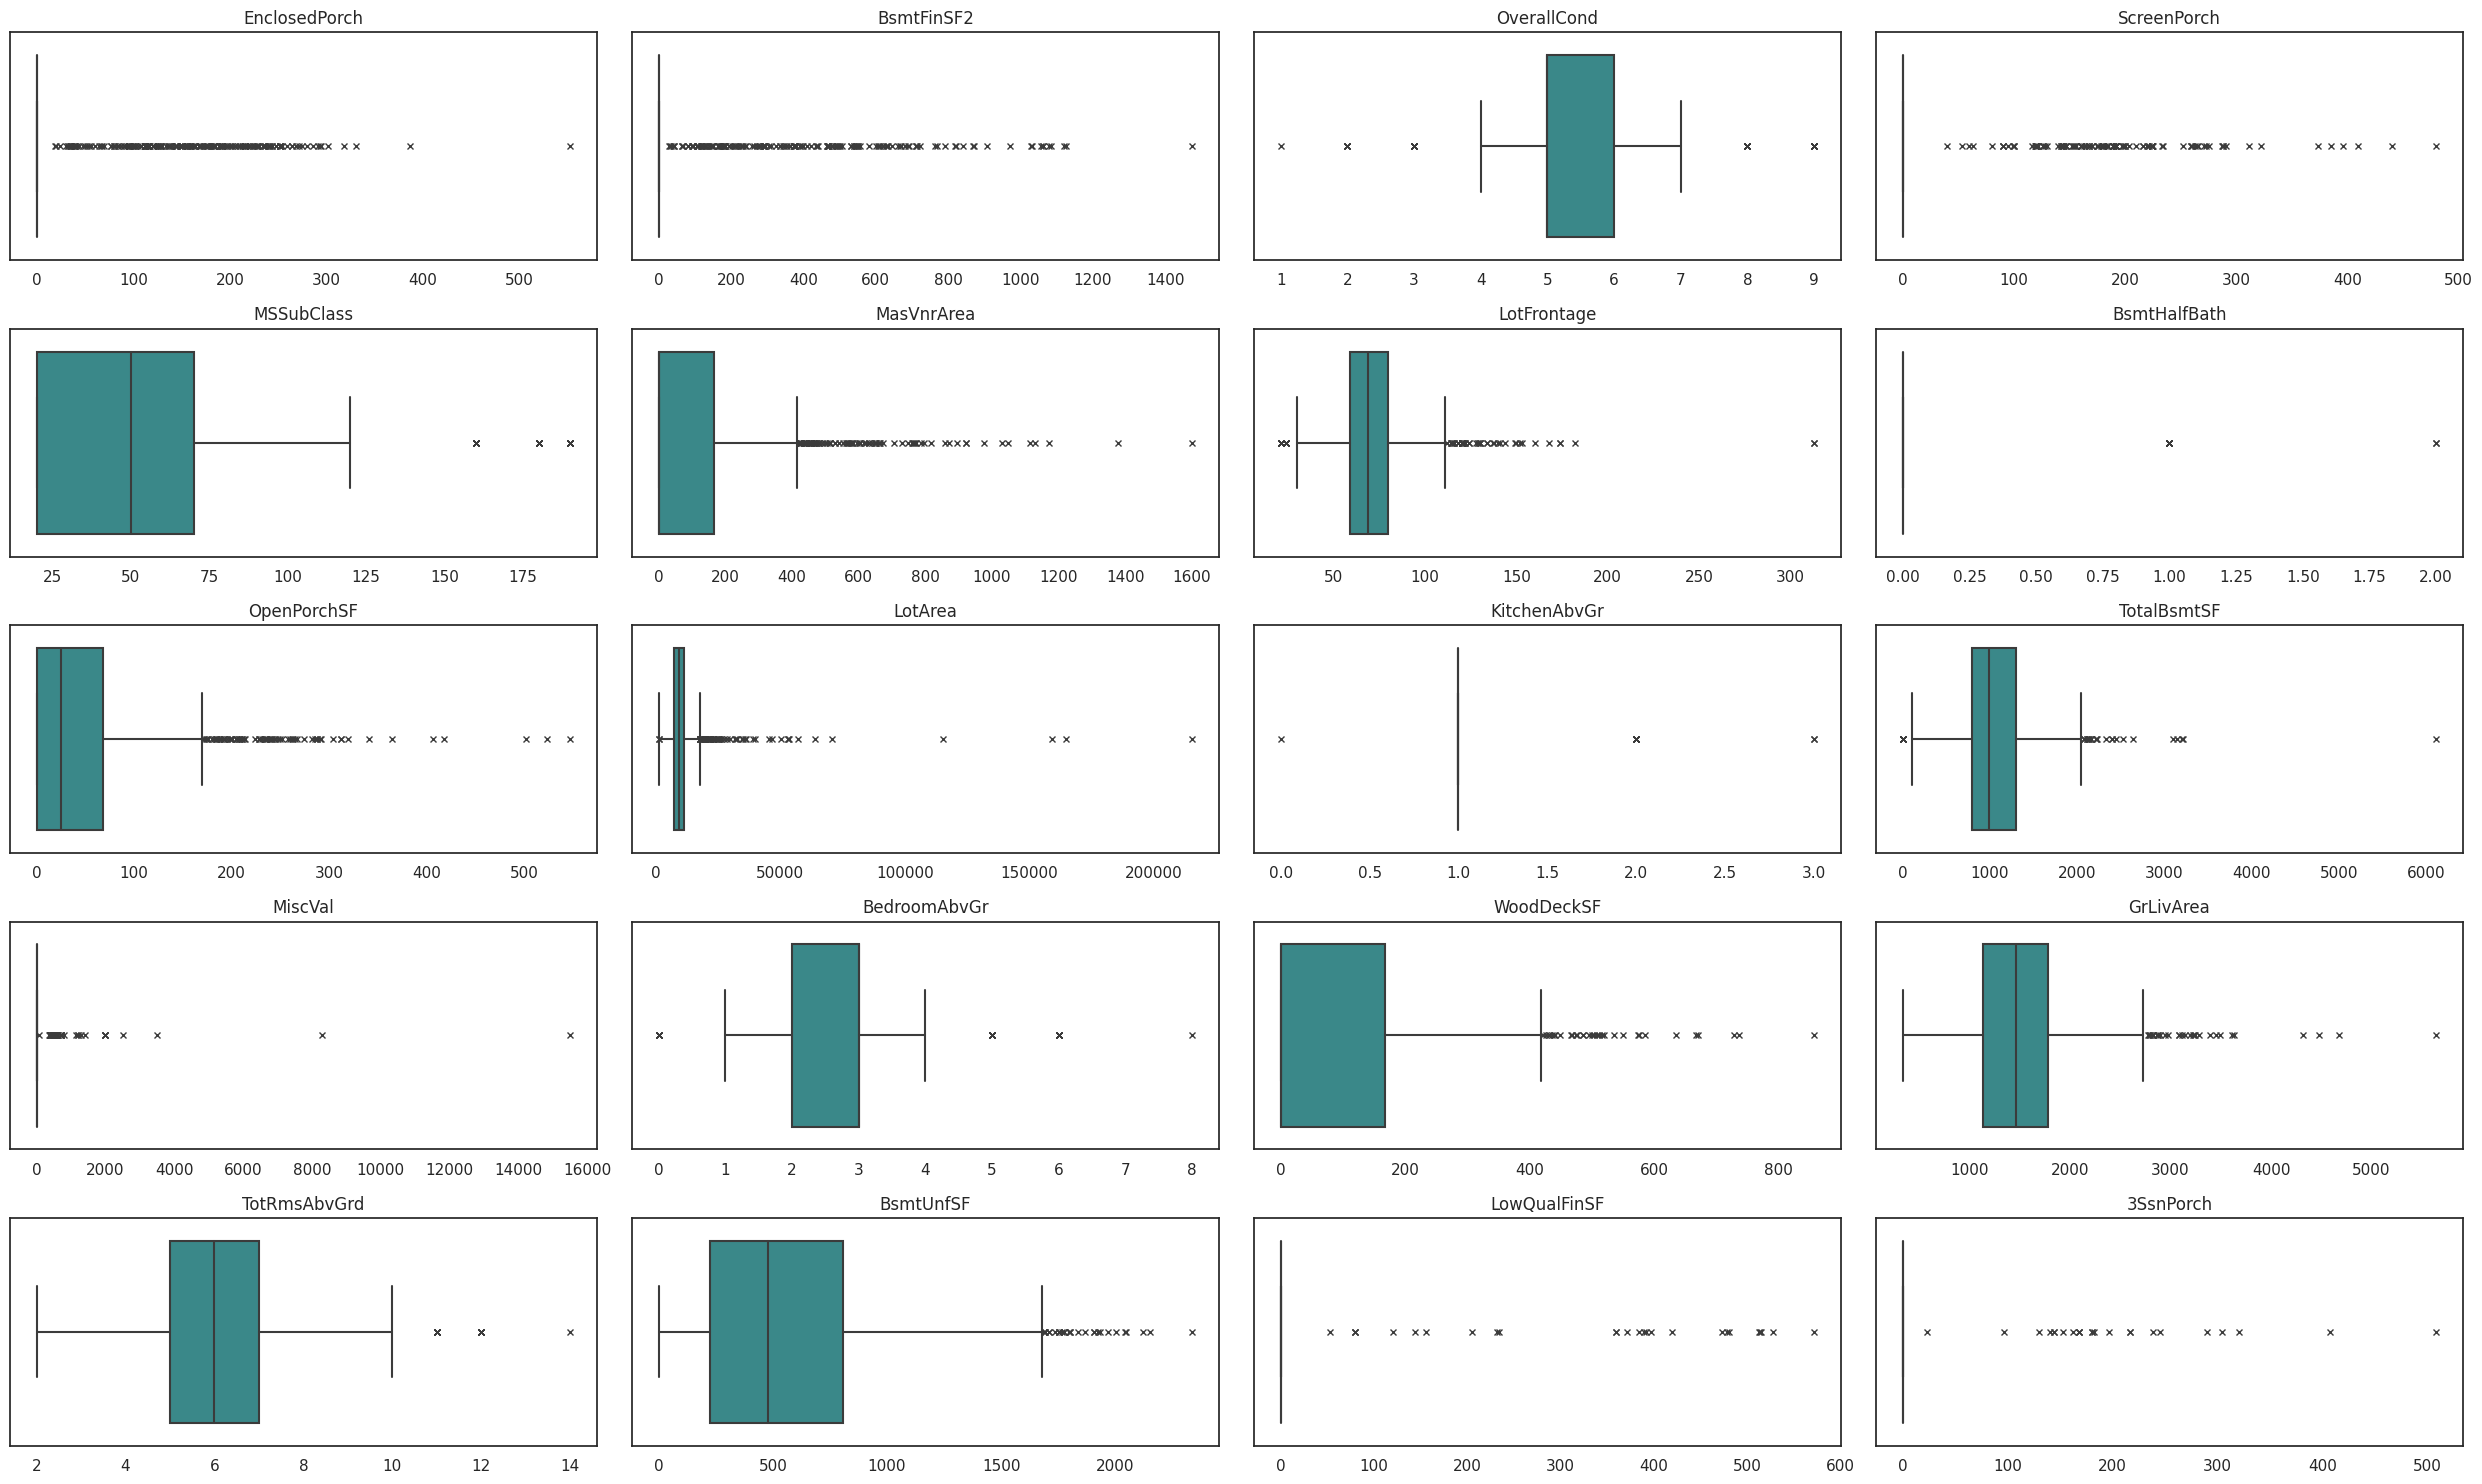

In [21]:
fig = plt.figure(figsize=(25,15))
for i,j in zip(out_df['Column'].head(20), range(1,len(out_df['Column'].head(20))+1)):
    plt.subplot(5,4,j)
    sns.boxplot(x=df[i],flierprops={"marker": "x"}, color='#2D9596').set(title=f'{i}',xlabel=None)
fig.tight_layout()

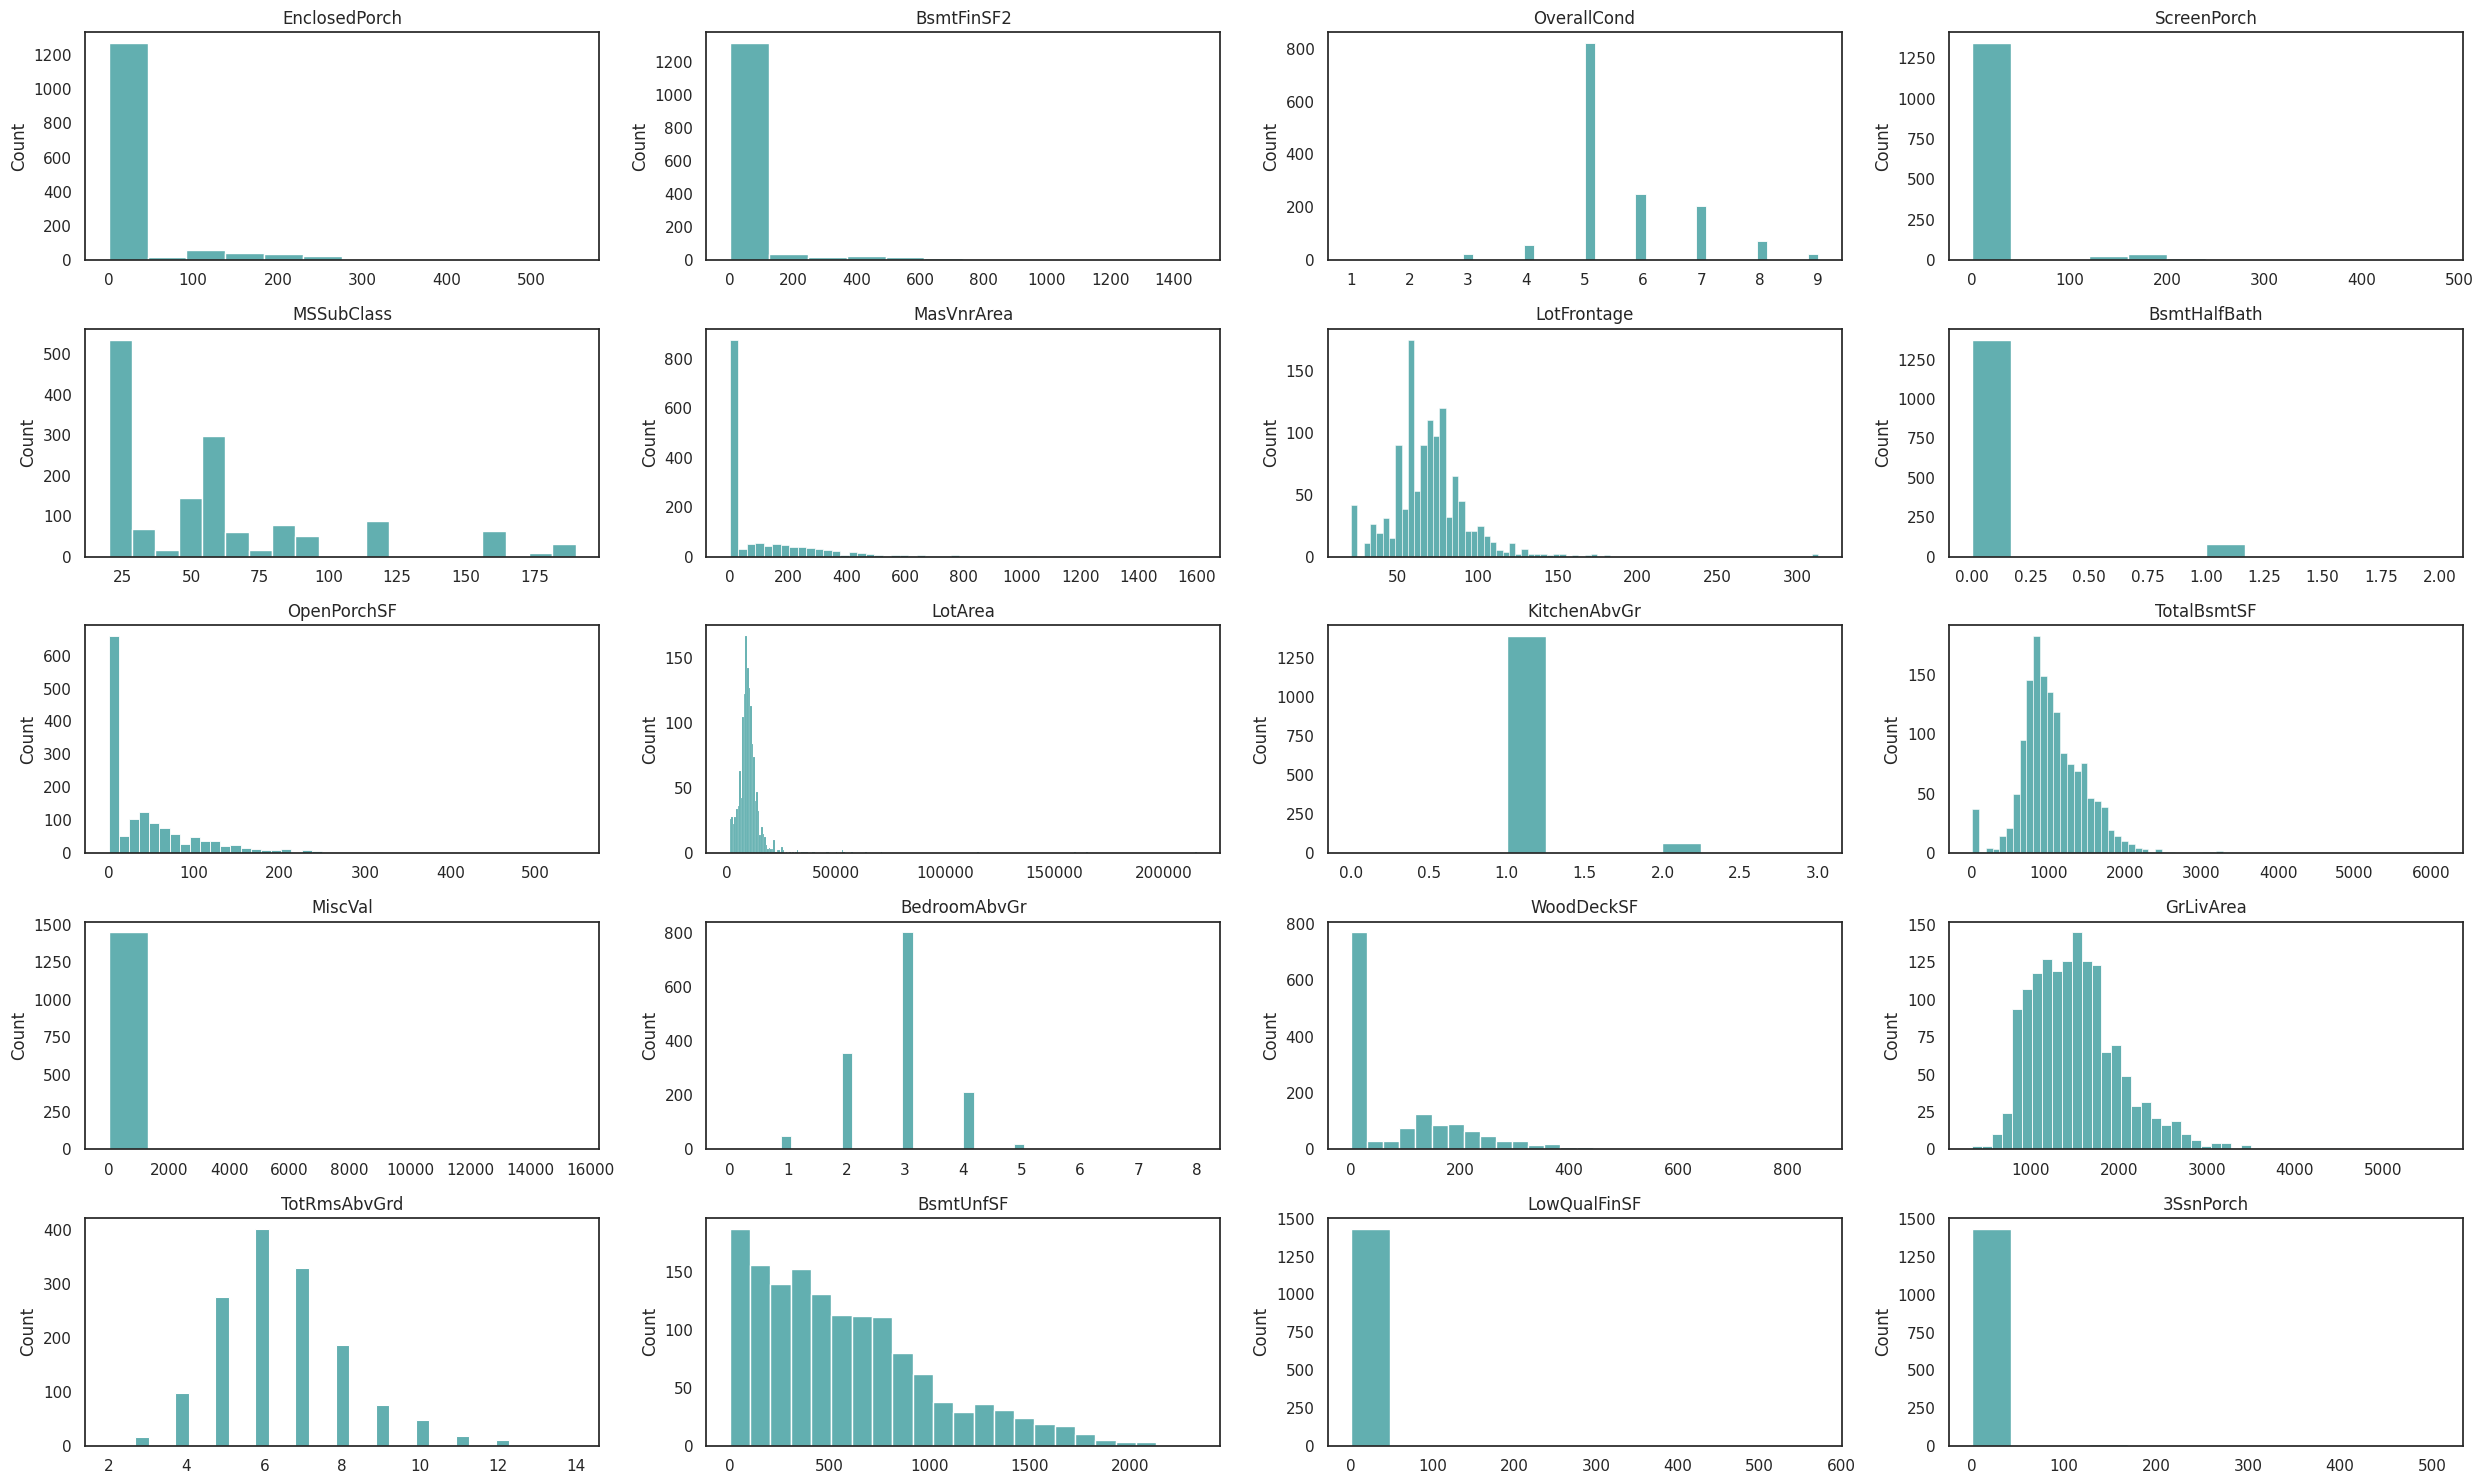

In [22]:
fig = plt.figure(figsize=(25,15))
for i,j in zip(out_df['Column'].head(20), range(1,len(out_df['Column'].head(20))+1)):
    plt.subplot(5,4,j)
    sns.histplot(x=df[i], color='#2D9596').set(title=f'{i}',xlabel=None)
fig.tight_layout()

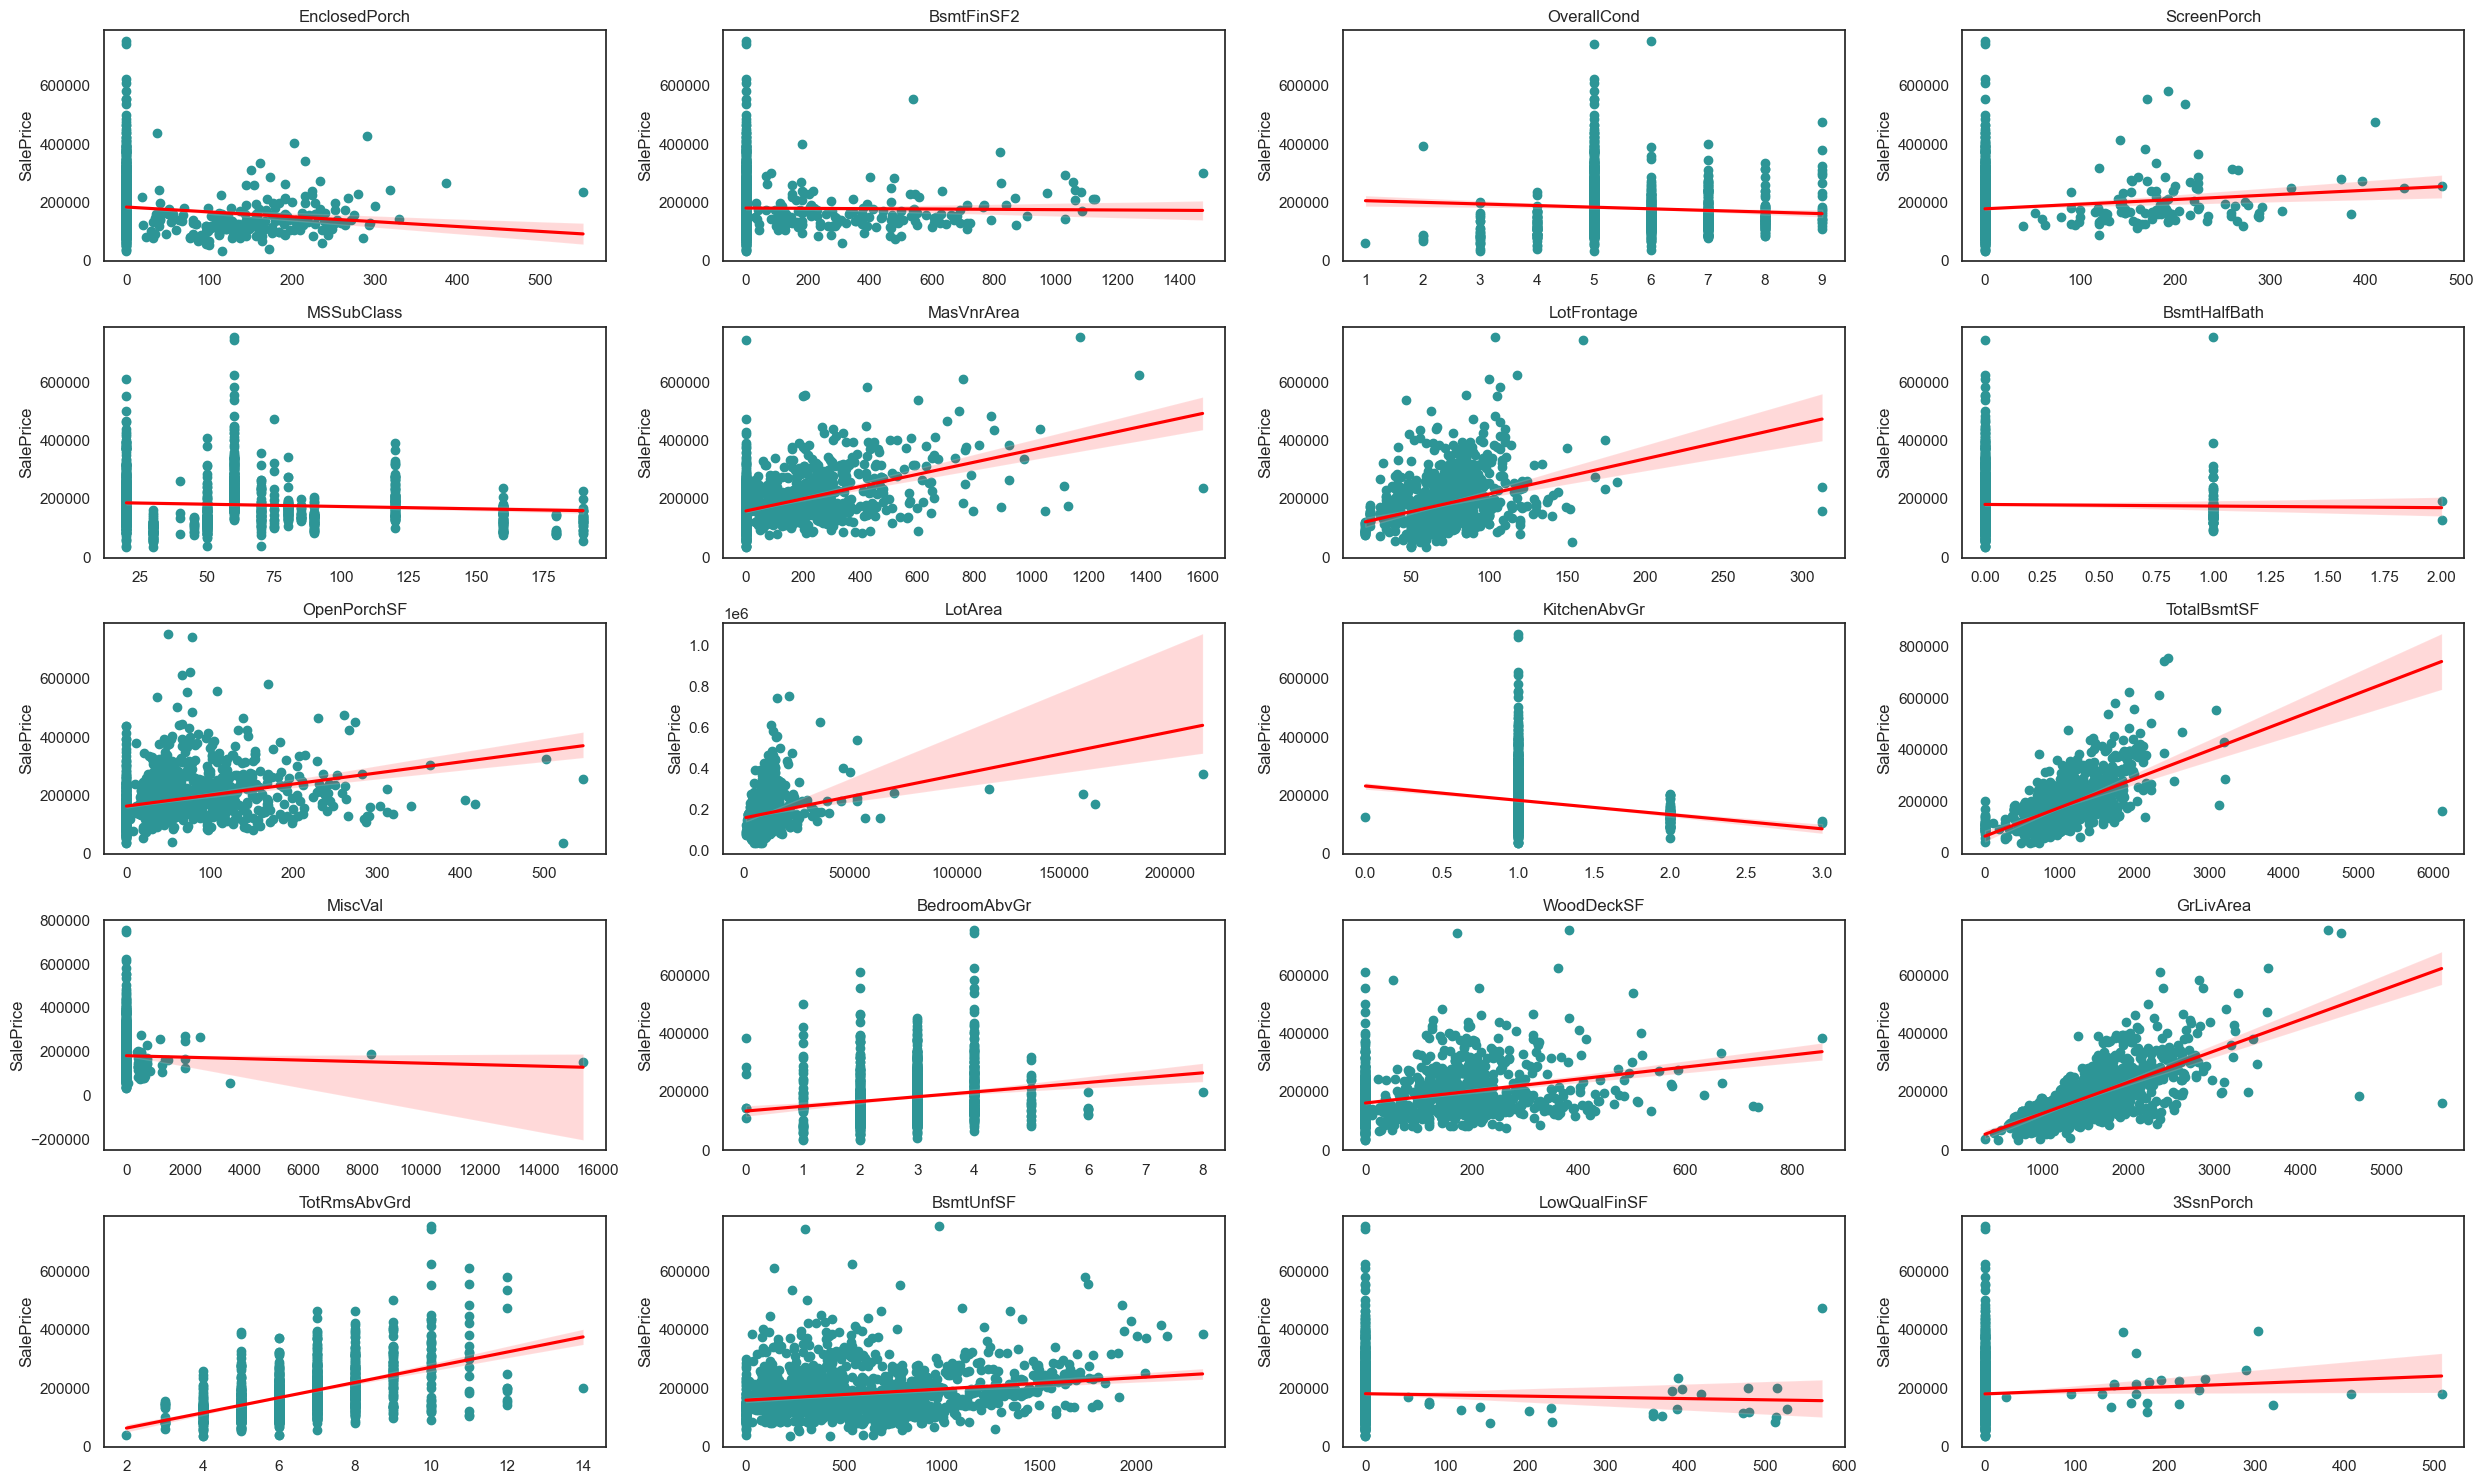

In [19]:
fig = plt.figure(figsize=(25,15)) 
for i,j in zip(out_df['Column'].head(20), range(1,len(out_df['Column'].head(20))+1)):
    plt.subplot(5,4,j)
    sns.regplot(
        x = df[i], 
        y = df['SalePrice'],
        scatter_kws = {
            "color": "#2D9596", 
            "alpha": 1},
        line_kws = {"color": "red"}
        ).set(title=f'{i}',xlabel=None)
fig.tight_layout()
plt.show()

Outlier dapat dihandle dengan beberapa metode, beberapa cara diantaranya: kita bisa drop outliernya, kita bisa juga mengganti value outlier menjadi value threshold IQR, kita bisa anggap outliernya sebagai missing value lalu kita gunakan KNN imputer untuk melakukan imputasi, kita bisa juga membiarkannya dan langsung ketahap melakukan feature transformation dan feature scaling untuk mengurangi outlier. Kali ini kita akan coba metode ketiga. 

Beberapa model bekerja dengan baik jika datanya berdistribusi normal, maka dari itu untuk mengurangi skewness kita akan melakukan tahapan berikut: 
- Feature Transformer yang kita gunakan adalah 'yeo-johnson'
- Feature scalernya kita gunakan 'Standard Scaler'

Untuk data yang variabilitynya rendah, akan terfilter nantinya kketika menggunakan Mutual Information

## Correlation Matrix

Multi Collinearity adalah kondisi dimana variable independen saling berkorelasi satu sama dengan yang lain, jika variable A dan variable B saling berkorelasi, kita harus drop salah satu kolom tersebut, kolom yang di drop adalah kolom yang korelasi dengan target variablenya lebih rendah. 

Kita akan coba untuk mengidentifikasi feature mana yang saling berkorelasi. Karena terlalu banyak jumlah kolom numerik yang kita punya, tidak mungkin kita menampilkan semua data kedalam heatmap plot, untuk itu kita harus buat threshold diawal untuk memfilter feature.

In [30]:
# function untuk mencari asosiasi data categorik
def cramers_v(confusion_matrix):
        """ calculate Cramers V statistic for categorial-categorial association.
            uses correction from Bergsma and Wicher,
            Journal of the Korean Statistical Society 42 (2013): 323-328
        """
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
def get_corr_mat(df, f=chi2_contingency):
        columns = df.columns
        dm = pd.DataFrame(index=columns, columns=columns)
        for var1, var2 in combinations(columns, 2):
            cont_table = pd.crosstab(df[var1], df[var2], margins=False)
            chi2_stat = cramers_v(cont_table.values)
            dm.loc[var2, var1] = chi2_stat
            dm.loc[var1, var2] = chi2_stat
        dm.fillna(1, inplace=True)
        return dm

# function untuk mencari korelasi data numerik
# masukkan dataframe kolom numerik tanpa target dan thresholdnya
def filter_corr(df, threshold,dtype):
    if dtype== 'num':
        df_corr = df.corr()
    elif dtype=='cat':
        df_corr = get_corr_mat(df)
    correlated_col = []
    for i in df_corr.columns: 
        series = df_corr[i].drop(index=i)
        for j in series[(series>threshold) | (series<-threshold)].index.to_list():
            correlated_col.append(j) 
    return pd.Series(correlated_col).unique().tolist()



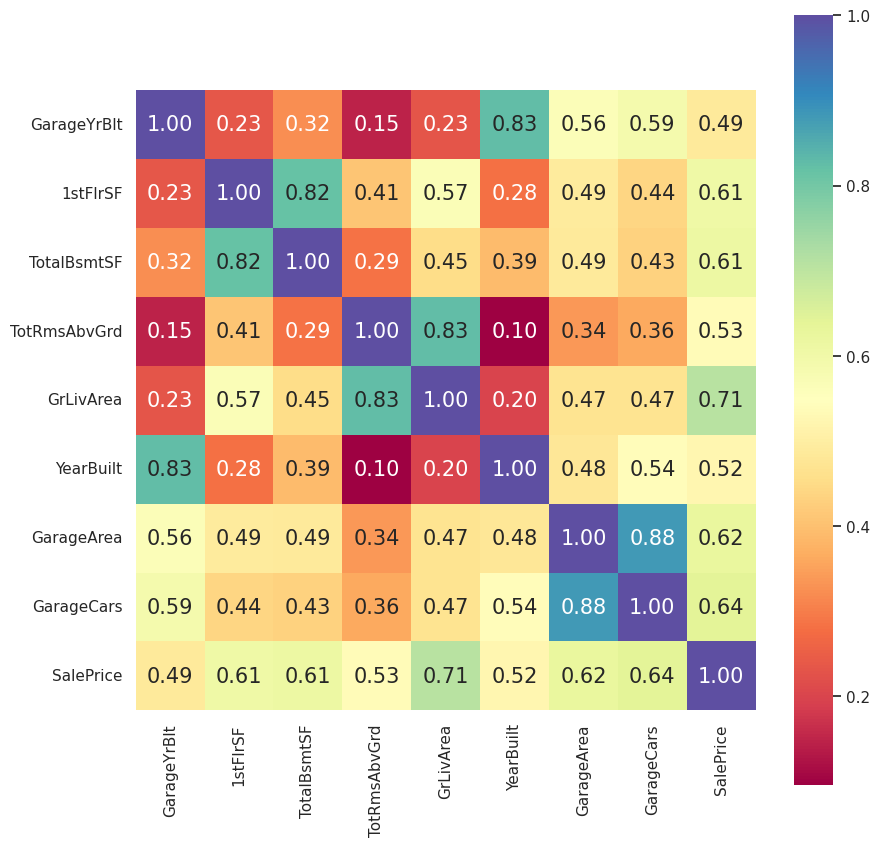

In [31]:
# tampilkan feature yang memiliki korelasi diatas 0.7
correlated_col = filter_corr(df[num_cols].drop(columns='SalePrice'),0.7,'num')

plt.figure(figsize=(10,10))
sns.heatmap(df[correlated_col+['SalePrice']].corr(),cbar=True, annot=True, fmt='.2f', square=True, annot_kws={'size': 15}, cmap='Spectral')
plt.show()

In [32]:
# berikut adalah list kolom yang perlu di drop dari correlation matrix feature numeric
df_corr= df[correlated_col].corr()
col_drop = []
for i in df_corr.columns:
    series = df_corr[i].drop(index=i)
    col_corr = series[series==series.max()].index.to_list()
    series2 = df[[i]+col_corr+['SalePrice']].corr()['SalePrice']
    col_drop.append(series2[series2==series2.min()].index.to_list()[0])
col_drop = pd.Series(col_drop).unique().tolist() 
col_drop

['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']

Pair plot 4 variable independen yang saling berkorelasi

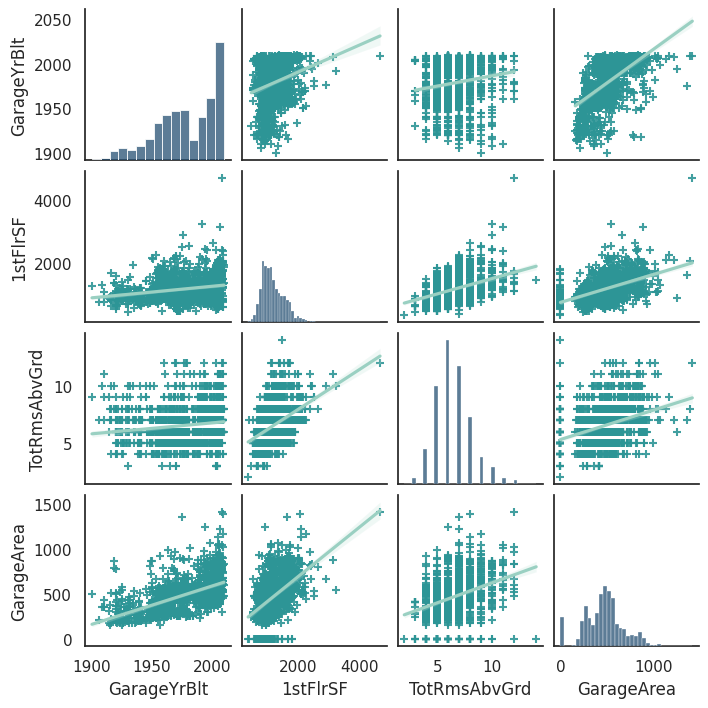

In [24]:
sns.pairplot(
    df[col_drop], 
    size = 1.8, 
    corner=False, 
    kind='reg',
    plot_kws={
        'marker':'+',
        'line_kws':{'color':'#9AD0C2'},
        'scatter_kws': {'alpha': 0.9,'color': '#2D9596'},
        },
    diag_kws= {'color': '#265073'}
    )
plt.show();

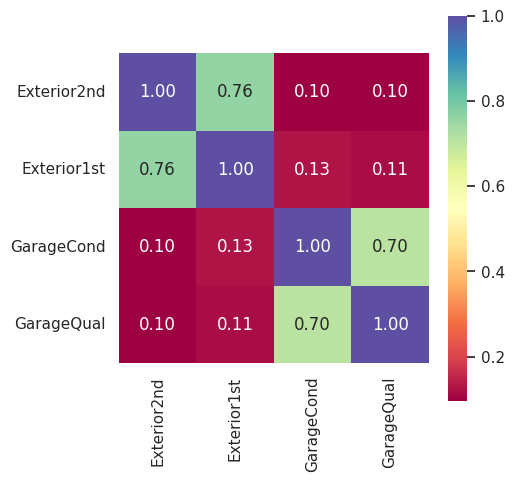

In [33]:
# categoric assosiation 
correlated_col = filter_corr(df[cat_cols],0.7,'cat')
cat_corr= get_corr_mat(df[correlated_col])
plt.figure(figsize=(5,5))
sns.heatmap(cat_corr,cbar=True, annot=True, fmt='.2f', square=True, annot_kws={'size': 12}, cmap='Spectral')
plt.show()

Dari 4 variable yang saling berkorelasi, kita akan pilih dua variable secara acak. Kali ini feature yang di drop adalah Exterior1st dan GarageCond


# Modeling

## Baseline Model

In [45]:
# model yang digunakan
models = [
    ['Random Forest',RandomForestRegressor()],
    ['LGBM',LGBMRegressor(verbose=0)],
    ['CatBoost',CatBoostRegressor(verbose=0)],
    ['XGBoost',xgb.XGBRegressor()],
    ['GradBoost',GradientBoostingRegressor()], 
]

In [46]:
# dataset splitting
X = df[num_cols[:-1] + cat_cols]
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
ordinal_encoder = OrdinalEncoder(handle_unknown= 'use_encoded_value',unknown_value=np.nan)
most_freq_imputer = SimpleImputer(strategy='most_frequent')
numeric_pipe = Pipeline([('most_freq_imputer', most_freq_imputer)])
categoric_pipe = Pipeline([('most_freq_imputer', most_freq_imputer),('ordinal_encoder', ordinal_encoder)])
column_transformer = ColumnTransformer([('numeric_pipe', numeric_pipe, num_cols[:-1]),('categoric_pipe', categoric_pipe, cat_cols)])
preprocessor = Pipeline([('column_transformer',column_transformer),('most_freq_imputer', most_freq_imputer)])


cv_df = [] 
for name, j in models:
    model_pipe = Pipeline([('preprocessor',preprocessor),('model',j)])
    score = cross_validate(model_pipe,X_train,y_train,cv=5,return_train_score=True, scoring=['r2'])
    mean_score = [] 
    for i in score.values(): 
        mean_score.append(round(np.mean(i),3))
    cv_df.append(pd.DataFrame({'Attribute':[i for i in score.keys()], f'{name}':mean_score }))
score = pd.DataFrame(columns=['Attribute'])
for i in cv_df:
    score = score.merge(right=i,on='Attribute', how='outer')
score = score.loc[2:].reset_index(drop=True) 
score 

,Attribute,Random Forest,LGBM,CatBoost,XGBoost,GradBoost
0,test_r2,0.857,0.863,0.884,0.861,0.859
1,train_r2,0.977,0.978,0.996,1.000,0.970


## Cross Validation and Feature Selection

### Pipeline

In [83]:
# kolom yang akan di drop berdasarkan correlation matrix
col_drop = ['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea','Exterior1st', 'GarageCond']

# imputer
knn_imputer = KNNImputer(n_neighbors=5)
most_freq_imputer = SimpleImputer(strategy='most_frequent')

# encoder
ordinal_encoder = OrdinalEncoder(handle_unknown= 'use_encoded_value',unknown_value=np.nan)
nominal_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
def CountEncoder(df):
    return np.array(pd.DataFrame(df).apply(lambda x: x.map(x.value_counts().to_dict())))
count_encoder = FunctionTransformer(CountEncoder)

# handling outliers
def OutliersTransformer(array):    
    df = pd.DataFrame(array)
    new_ser = []
    for i in df.columns:
        q1=df[i].quantile(0.25)
        q3= df[i].quantile(0.75)
        IQR=q3-q1 
        upper_bound = (q3+1.5*IQR) 
        lower_bound = (q1-1.5*IQR)
        df[i] = df[i].apply(lambda x: upper_bound if (x > upper_bound) else x ).apply(lambda x: lower_bound if (x < lower_bound) else x ) 
    return np.array(df)
outlier_trans = FunctionTransformer(OutliersTransformer)

# scaler dan transformer
scaler = MinMaxScaler()
power = PowerTransformer(method='yeo-johnson')

# numeric pipe
numeric_pipe = Pipeline([
    ('imputer', knn_imputer),
    ('outlier_trans',outlier_trans),
    ('power', power) ,
    ('scaler', scaler)])

# ordinal pipe
ordinal_pipe = Pipeline([
    ('most_freq_imputer', most_freq_imputer),
    ('ordinal_encoder', ordinal_encoder),
    ('scaler', scaler)])

# nominal pipe (OneHot)
nominal_pipe = Pipeline([
    ('most_freq_imputer', most_freq_imputer),
    ('nominal_encoder', nominal_encoder)])

# nominal (CountEncoder)
nominal_pipe_count = Pipeline([
    ('most_freq_imputer', most_freq_imputer),
    ('nominal_encoder', count_encoder),
    ('scaler', scaler)])

num_var = [ i for i in num_cols[:-1] if i not in col_drop]
nom_var = [i for i in cat_nom_cols if i not in card_df['Column'].to_list() + col_drop]
nom_var_count = [i for i in card_df['Column'].to_list() if i not in col_drop]

column_transformer = ColumnTransformer([
    ('numeric_pipe', numeric_pipe, num_var),
    ('ordinal_pipe', ordinal_pipe, [i for i in cat_ord_cols if i not in col_drop]),
    ('nominal_pipe', nominal_pipe, nom_var),
    ('nominal_pipe_count', nominal_pipe_count, nom_var_count)
])

# dataset splitting
X = df[num_cols[:-1] + cat_cols].drop(columns=col_drop)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1241, 73), (219, 73), (1241,), (219,))

### Feature Selection

In [85]:
# function untuk feature selection
# untuk melakukan anova feature selection, masukkan parameter f_classif untuk klasifikasi, dan f_regression untuk regresi
# sedangkan untuk mutual information , mutual_info_classif untuk klasifikasi, mutual_info_regression untuk regresi 
main_color = ['#26577C','#E55604']
def select_features(X_train, y_train, X_test,method,k):
    fs = SelectKBest(score_func=method, k=k) # setting jumlah fitur yang ingin diambil
    fs.fit(X_train, y_train) # pelajari hubungan dari data training
    X_train_fs = fs.transform(X_train) # transform data train
    X_test_fs = fs.transform(X_test) # transform data test
    return X_train_fs, X_test_fs, fs
# function visualisasi feature selection
def viz_feature_select(var,feature_selection_score,title_,height):
    df = pd.DataFrame({'Variable':var,'Score':[round(i,2) for i in feature_selection_score]}).sort_values(by='Score', ignore_index=True,ascending=False)
    df['Color'] = main_color[0] 
    df['Color'][:5] = main_color[1] # top 5 kolom terbaik, bedakan warnanya
    fig = go.Figure([go.Bar(y=df['Variable'], x=df['Score'],text= [ '{a} (%{b})'.format(a=i,b=j) for i, j in zip(df['Score'],[round((i / df['Score'].sum())* 100,2) for i in df['Score']])],
                            textposition='outside',
                            marker={'color': df['Color']},
                            orientation='h')]) 
    fig.update_layout(autosize=False,width=1200,height=height,margin=dict(l=10,r=10,b=10,t=40,pad=0),xaxis_range=[0,df['Score'].max() + (df['Score'].max()/2)],
            title=dict(text=title_,font=dict(size=20),x=0.5),
            yaxis={'categoryorder':'array','categoryarray':df.sort_values(by='Score', ascending=True)['Variable'].to_list()}, template='plotly_white')  
    return df,fig

# preprocessor untuk feature selection 
preprocessor_fs = Pipeline([('column_transformer',column_transformer),('most_freq_imputer', most_freq_imputer)])

X_train_fs, X_test_fs, fs = select_features(
    pd.DataFrame(preprocessor_fs.fit_transform(X_train,y_train)), 
    y_train, 
    pd.DataFrame(preprocessor_fs.transform(X_test)) , 
    mutual_info_regression,
    'all') 
# untuk mendapatkan nama  kolom yang sudah di preprocess
trans_num = preprocessor_fs[0].transformers_[0][1].get_feature_names_out().tolist()
trans_num = preprocessor_fs[0].transformers_[0][2]
trans_ord = preprocessor_fs[0].transformers_[1][1].get_feature_names_out().tolist()
trans_nom = preprocessor_fs[0].transformers_[2][1].get_feature_names_out().tolist()
trans_nom_count= preprocessor_fs[0].transformers_[3][2]
trans_col = trans_num + trans_ord + trans_nom + trans_nom_count

mutual_df = pd.DataFrame({'col':trans_col,'score':fs.scores_}).sort_values(by='score', ignore_index=True, ascending=False)

# viz_feature_select(trans_col,fs.scores_,'Mutual Information Feature Selection',2200)[1].show()
viz_feature_select(mutual_df['col'].head(10),mutual_df['score'].head(10),'Mutual Information Feature Selection (Top 10)',600)[1].show()

In [31]:
percent_useless_feature = mutual_df[mutual_df['score']==0].shape[0] / mutual_df.shape[0]
print('Persentase Feature yang tidak berguna :',round(percent_useless_feature*100,3),'%')

Persentase Feature yang tidak berguna : 22.148 %


Karena feature yang berguna hanya sekitar 80%, kita akan manfaatkan SelectPercentile dari scikitlearn untuk melakukan eliminasi feature secara otomatis di pipeline

## Cross Validation

In [32]:
# feature selecttion
selection = SelectPercentile(mutual_info_regression, percentile=80)

# preprocessor
preprocessor = Pipeline([
    ('column_transformer',column_transformer),
    ('most_freq_imputer', most_freq_imputer),
    ('selection',selection)
                    ])

scoring = {
    'RMSE': make_scorer(mean_squared_error, squared=False),
    'R2': make_scorer(r2_score),
}

# cross validation
cv_df = [] 
for name, j in models:
    model_pipe = Pipeline([('preprocessor',preprocessor),('model',j)])
    score = cross_validate(model_pipe,X_train,y_train,cv=5,return_train_score=True, scoring=scoring)
    mean_score = [] 
    for i in score.values(): 
        mean_score.append(round(np.mean(i),3))
    cv_df.append(pd.DataFrame({'Attribute':[i for i in score.keys()], f'{name}':mean_score }))
score = pd.DataFrame(columns=['Attribute'])
for i in cv_df:
    score = score.merge(right=i,on='Attribute', how='outer')
score = score.loc[2:].reset_index(drop=True) 

In [33]:
score 

,Attribute,Random Forest,LGBM,CatBoost,XGBoost,GradBoost
0,test_RMSE,29757.182,29335.355,27641.909,29687.274,27355.837
1,train_RMSE,11229.764,11525.563,4703.195,860.793,13528.347
2,test_R2,0.850,0.854,0.871,0.852,0.872
3,train_R2,0.979,0.978,0.996,1.000,0.969


tidak terjadi perubahan yang signifikan pada scorenya, yang berubah hanya jumlah featurenya saja. yang awalnya 155 feature (setelah preprocessing), menjadi hanya 119 feature. Artinya kita berhasil melakukan efisiensi.

## Hyperparameter tuning

In [34]:
model_param = {'Random Forest':[grid_search_params.rf_params,RandomForestRegressor()],
'LGBM':[{'algo__n_estimators':[100,200,300],'algo__learning_rate':[0.01,0.1,],'algo__num_leaves':[20,50]},LGBMRegressor() ] ,
'CatBoost':[{'algo__max_depth': [ 3,6,10]}, CatBoostRegressor(verbose=0)],
'XGBoost':[{'algo__max_depth': [3,6,10],'algo__colsample_bytree': [0.4, 0.6, 0.8],'algo__n_estimators': [100, 150, 200]},xgb.XGBRegressor()],
'GradBoost':[{'algo__max_depth': [3,6,10],'algo__n_estimators': [100, 150, 200]},GradientBoostingRegressor()]}

model_col = []
gs_score = [] 
for i,j in model_param.items():
    model_pipe = Pipeline([ ('prep',preprocessor),('algo',j[1])])
    param = j[0]
    model = GridSearchCV(estimator=model_pipe,param_grid=param, cv=5, scoring=make_scorer(mean_squared_error, squared=False), verbose=0)
    model.fit(X_train, y_train)
    gs_score.append({'model':i,'best score':model.best_score_,'best params':model.best_params_,'estimator':model.best_estimator_}) 
    model_col.append(model) 

In [35]:
gs_df = pd.DataFrame(gs_score, columns=['model','best score','best params','estimator']).sort_values(by='best score',ignore_index=True,ascending=True)
best_estimator = gs_df.iloc[0,3]
gs_df 

,model,best score,best params,estimator
0,CatBoost,29192.503903,{'algo__max_depth': 10},((ColumnTransformer(transformers=[('numeric_pi...
1,Random Forest,31278.608196,"{'algo__max_depth': 80, 'algo__max_features': ...",((ColumnTransformer(transformers=[('numeric_pi...
2,XGBoost,33437.208128,"{'algo__colsample_bytree': 0.4, 'algo__max_dep...",((ColumnTransformer(transformers=[('numeric_pi...
3,GradBoost,35167.203600,"{'algo__max_depth': 10, 'algo__n_estimators': ...",((ColumnTransformer(transformers=[('numeric_pi...
4,LGBM,42175.305406,"{'algo__learning_rate': 0.01, 'algo__n_estimat...",((ColumnTransformer(transformers=[('numeric_pi...


CatBoost muncul sebagai pemenang dengan RMSE terendah, sekarang kita coba predict data tesnya

In [55]:
y_pred = best_estimator.predict(X_test)
score_r2= r2_score(y_true=y_test, y_pred=y_pred)
score_rmse = mean_squared_error(y_true=y_test, y_pred=y_pred,squared=False)
print('R2 :', score_r2)
print('RMSE :', score_rmse)

R2 : 0.8668186980613689

RMSE : 32882.23366776396


## Voting Regressor

Sekarang kita coba bereksperimen, bagaimana jika top 3 model terbaik, digabungkan menjadi satu untuk melakukan prediksi? 

In [56]:
vt_reg = VotingRegressor([
    (gs_df.iloc[0,0],gs_df.iloc[0,3]),
    (gs_df.iloc[1,0],gs_df.iloc[1,3]),
    (gs_df.iloc[2,0],gs_df.iloc[2,3])
])
vt_reg.fit(X_train,y_train)

y_pred = vt_reg.predict(X_test) 
score_r2= r2_score(y_true=y_test, y_pred=y_pred)
score_rmse = mean_squared_error(y_true=y_test, y_pred=y_pred,squared=False)
print('R2 :', score_r2)
print('RMSE :', score_rmse)

R2 : 0.8815803848110944

RMSE : 31006.41145977047


Ternyata hasilnya lebih baik daripada hanya menggunakan CatBoost saja, jadi kita akan gunakan model gabungan ini.

## Model Evaluation

prediksi dan data aktualnya saling membayangi, ini merupakan indikasi yang bagus

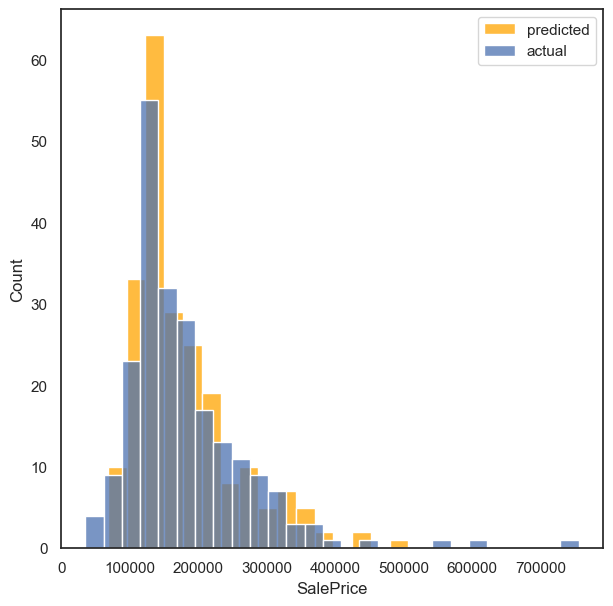

In [63]:
# actual vs prediction
plt.figure(figsize=(7,7))
sns.histplot(y_pred, label='predicted', color='orange')
sns.histplot(y_test, label='actual')
plt.legend()
plt.show()

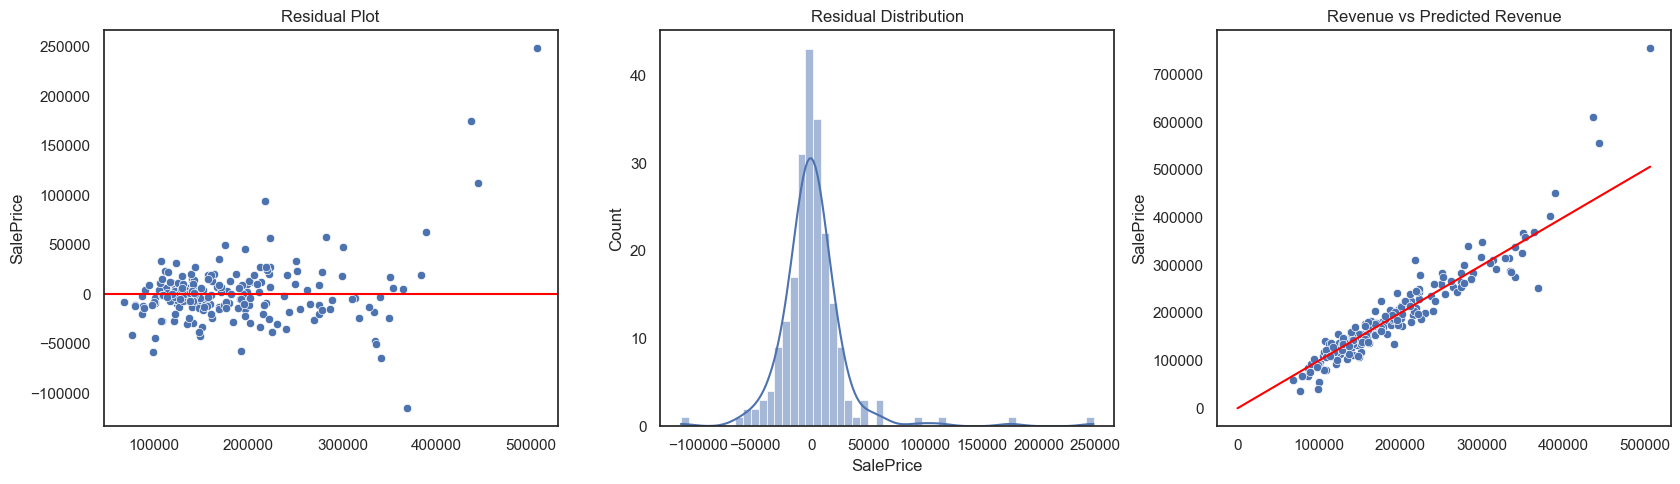

In [101]:
fig, axes = plt.subplots( nrows=1, ncols=3,figsize = (17,5))

# col 1
residual = y_test - y_pred
sns.scatterplot(x=y_pred, y=residual,ax=axes[0]).axhline(y=0.5, color='red', linestyle='-')
axes[0].set_title('Residual Plot')

# col 2
sns.histplot(residual, kde=True, ax=axes[1]).set_title('Residual Distribution')

# col 3
pd.Series(y_pred).name = 'Predicted Revenue'
sns.scatterplot( x=y_pred, y=y_test, ax=axes[2]).set_title('Revenue vs Predicted Revenue')
point1 = [0, 0]
point2 = [140000, 140000]
x_plot = [point1[0], point2[0]] 
y_plot = [point1[1], point2[1]]
plt.plot([0,y_pred.max()], [0,y_pred.max()], color='red')

plt.tight_layout()
plt.show()

Terdapat pola di residual plotnya, dimana model kurang berhasil memprediksi harga rumah yang harganya diatas 400000. Mungkin ini efek dari kita mengubah data outlier menjadi data terbesar yang tidak termasuk outlier (Threshold). Untuk pengembangan kedepannya, kita harus mengatur ulang thresholdnya agar tidak terlalu ketat. 